In [11]:
# Challenge de Clasificación de Literatura Médica
# Análisis Exploratorio de Datos y Modelado

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, hamming_loss, f1_score
from sklearn.preprocessing import MultiLabelBinarizer
import re
import nltk
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("✅ Librerías importadas correctamente")
print("🎯 Challenge de Clasificación de Literatura Médica")

✅ Librerías importadas correctamente
🎯 Challenge de Clasificación de Literatura Médica


In [12]:
# Cargar el dataset
df = pd.read_csv('challenge_data-18-ago.csv', sep=';')

print("📊 INFORMACIÓN GENERAL DEL DATASET")
print("="*50)
print(f"Número de registros: {len(df):,}")
print(f"Número de columnas: {df.shape[1]}")
print(f"Tamaño en memoria: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\n📋 ESTRUCTURA DEL DATASET")
print("="*50)
print(df.info())

print("\n🔍 PRIMEROS REGISTROS")
print("="*50)
df.head()

📊 INFORMACIÓN GENERAL DEL DATASET
Número de registros: 3,565
Número de columnas: 3
Tamaño en memoria: 3.16 MB

📋 ESTRUCTURA DEL DATASET
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3565 entries, 0 to 3564
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     3565 non-null   object
 1   abstract  3565 non-null   object
 2   group     3565 non-null   object
dtypes: object(3)
memory usage: 83.7+ KB
None

🔍 PRIMEROS REGISTROS


,title,abstract,group
0,Adrenoleukodystrophy: survey of 303 cases: bio...,Adrenoleukodystrophy ( ALD ) is a genetically ...,neurological|hepatorenal
1,endoscopy reveals ventricular tachycardia secrets,Research question: How does metformin affect c...,neurological
2,dementia and cholecystitis: organ interplay,Purpose: This randomized controlled study exam...,hepatorenal
3,The interpeduncular nucleus regulates nicotine...,Partial lesions were made with kainic acid in ...,neurological
4,guillain-barre syndrome pathways in leukemia,Hypothesis: statins improves stroke outcomes v...,neurological


🏥 ANÁLISIS DE CATEGORÍAS MÉDICAS
Categorías únicas encontradas: ['neurological', 'hepatorenal', 'cardiovascular', 'oncological']
Total de categorías: 4

📈 DISTRIBUCIÓN DE CATEGORÍAS
neurological   : 1,785 registros ( 50.1%)
cardiovascular : 1,268 registros ( 35.6%)
hepatorenal    : 1,091 registros ( 30.6%)
oncological    :  601 registros ( 16.9%)


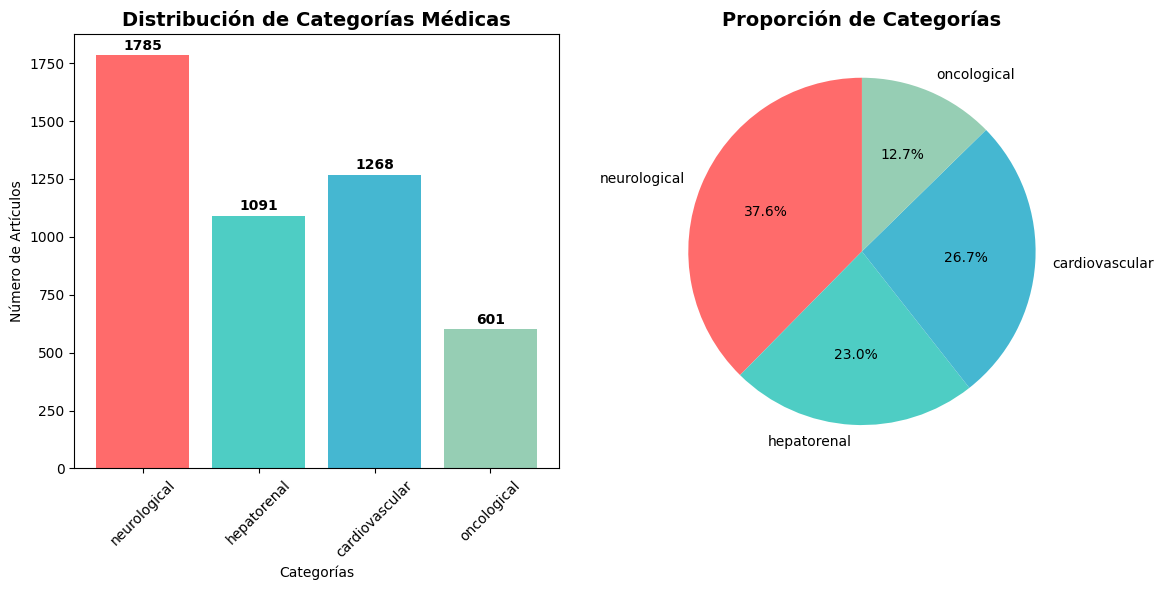

In [13]:
# Análisis de las categorías médicas (multi-label)
print("🏥 ANÁLISIS DE CATEGORÍAS MÉDICAS")
print("="*50)

# Separar las categorías múltiples
df['groups_list'] = df['group'].str.split('|')

# Obtener todas las categorías únicas
all_categories = []
for groups in df['groups_list']:
    all_categories.extend(groups)

category_counts = Counter(all_categories)
print(f"Categorías únicas encontradas: {list(category_counts.keys())}")
print(f"Total de categorías: {len(category_counts)}")

print("\n📈 DISTRIBUCIÓN DE CATEGORÍAS")
print("="*50)
for category, count in category_counts.most_common():
    percentage = (count / len(df)) * 100
    print(f"{category:15}: {count:4,} registros ({percentage:5.1f}%)")

# Visualización de la distribución
plt.figure(figsize=(12, 6))
categories = list(category_counts.keys())
counts = list(category_counts.values())

plt.subplot(1, 2, 1)
bars = plt.bar(categories, counts, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
plt.title('Distribución de Categorías Médicas', fontsize=14, fontweight='bold')
plt.xlabel('Categorías')
plt.ylabel('Número de Artículos')
plt.xticks(rotation=45)
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, 
             str(count), ha='center', va='bottom', fontweight='bold')

plt.subplot(1, 2, 2)
plt.pie(counts, labels=categories, autopct='%1.1f%%', startangle=90, 
        colors=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
plt.title('Proporción de Categorías', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

🔗 ANÁLISIS MULTI-LABEL
Distribución por número de categorías:
1 categoría(s): 2,473 artículos ( 69.4%)
2 categoría(s): 1,011 artículos ( 28.4%)
3 categoría(s):   74 artículos (  2.1%)
4 categoría(s):    7 artículos (  0.2%)


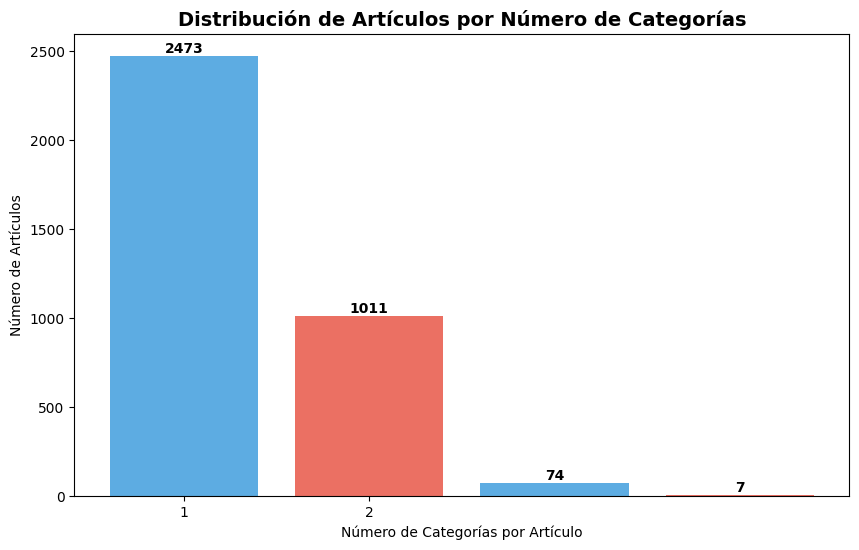


🔍 COMBINACIONES DE CATEGORÍAS
Top 10 combinaciones más frecuentes:
neurological                  : 1,058 (29.7%)
cardiovascular                : 645 (18.1%)
hepatorenal                   : 533 (15.0%)
neurological|cardiovascular   : 308 ( 8.6%)
oncological                   : 237 ( 6.6%)
neurological|hepatorenal      : 202 ( 5.7%)
cardiovascular|hepatorenal    : 190 ( 5.3%)
neurological|oncological      : 143 ( 4.0%)
hepatorenal|oncological       :  98 ( 2.7%)
cardiovascular|oncological    :  70 ( 2.0%)


In [14]:
# Análisis de combinaciones multi-label
print("🔗 ANÁLISIS MULTI-LABEL")
print("="*50)

# Contar artículos con múltiples categorías
df['num_categories'] = df['groups_list'].apply(len)
multi_label_stats = df['num_categories'].value_counts().sort_index()

print("Distribución por número de categorías:")
for num_cats, count in multi_label_stats.items():
    percentage = (count / len(df)) * 100
    print(f"{num_cats} categoría(s): {count:4,} artículos ({percentage:5.1f}%)")

# Visualizar distribución multi-label
plt.figure(figsize=(10, 6))
plt.bar(multi_label_stats.index, multi_label_stats.values, 
        color=['#3498db', '#e74c3c'], alpha=0.8)
plt.title('Distribución de Artículos por Número de Categorías', fontsize=14, fontweight='bold')
plt.xlabel('Número de Categorías por Artículo')
plt.ylabel('Número de Artículos')
plt.xticks([1, 2])
for i, v in enumerate(multi_label_stats.values):
    plt.text(multi_label_stats.index[i], v + 20, str(v), ha='center', fontweight='bold')
plt.show()

print("\n🔍 COMBINACIONES DE CATEGORÍAS")
print("="*50)
# Analizar combinaciones específicas
combination_counts = df['group'].value_counts()
print("Top 10 combinaciones más frecuentes:")
for combo, count in combination_counts.head(10).items():
    percentage = (count / len(df)) * 100
    print(f"{combo:30}: {count:3,} ({percentage:4.1f}%)")

📝 ANÁLISIS DE CARACTERÍSTICAS DE TEXTO
Estadísticas de longitud de texto:
                     Títulos  Abstracts  Texto_Completo
Caracteres_Promedio    69.35     696.55          766.89
Caracteres_Std         36.67     579.56          606.65
Palabras_Promedio       8.73     100.06          108.79
Palabras_Std            4.88      93.07           96.62


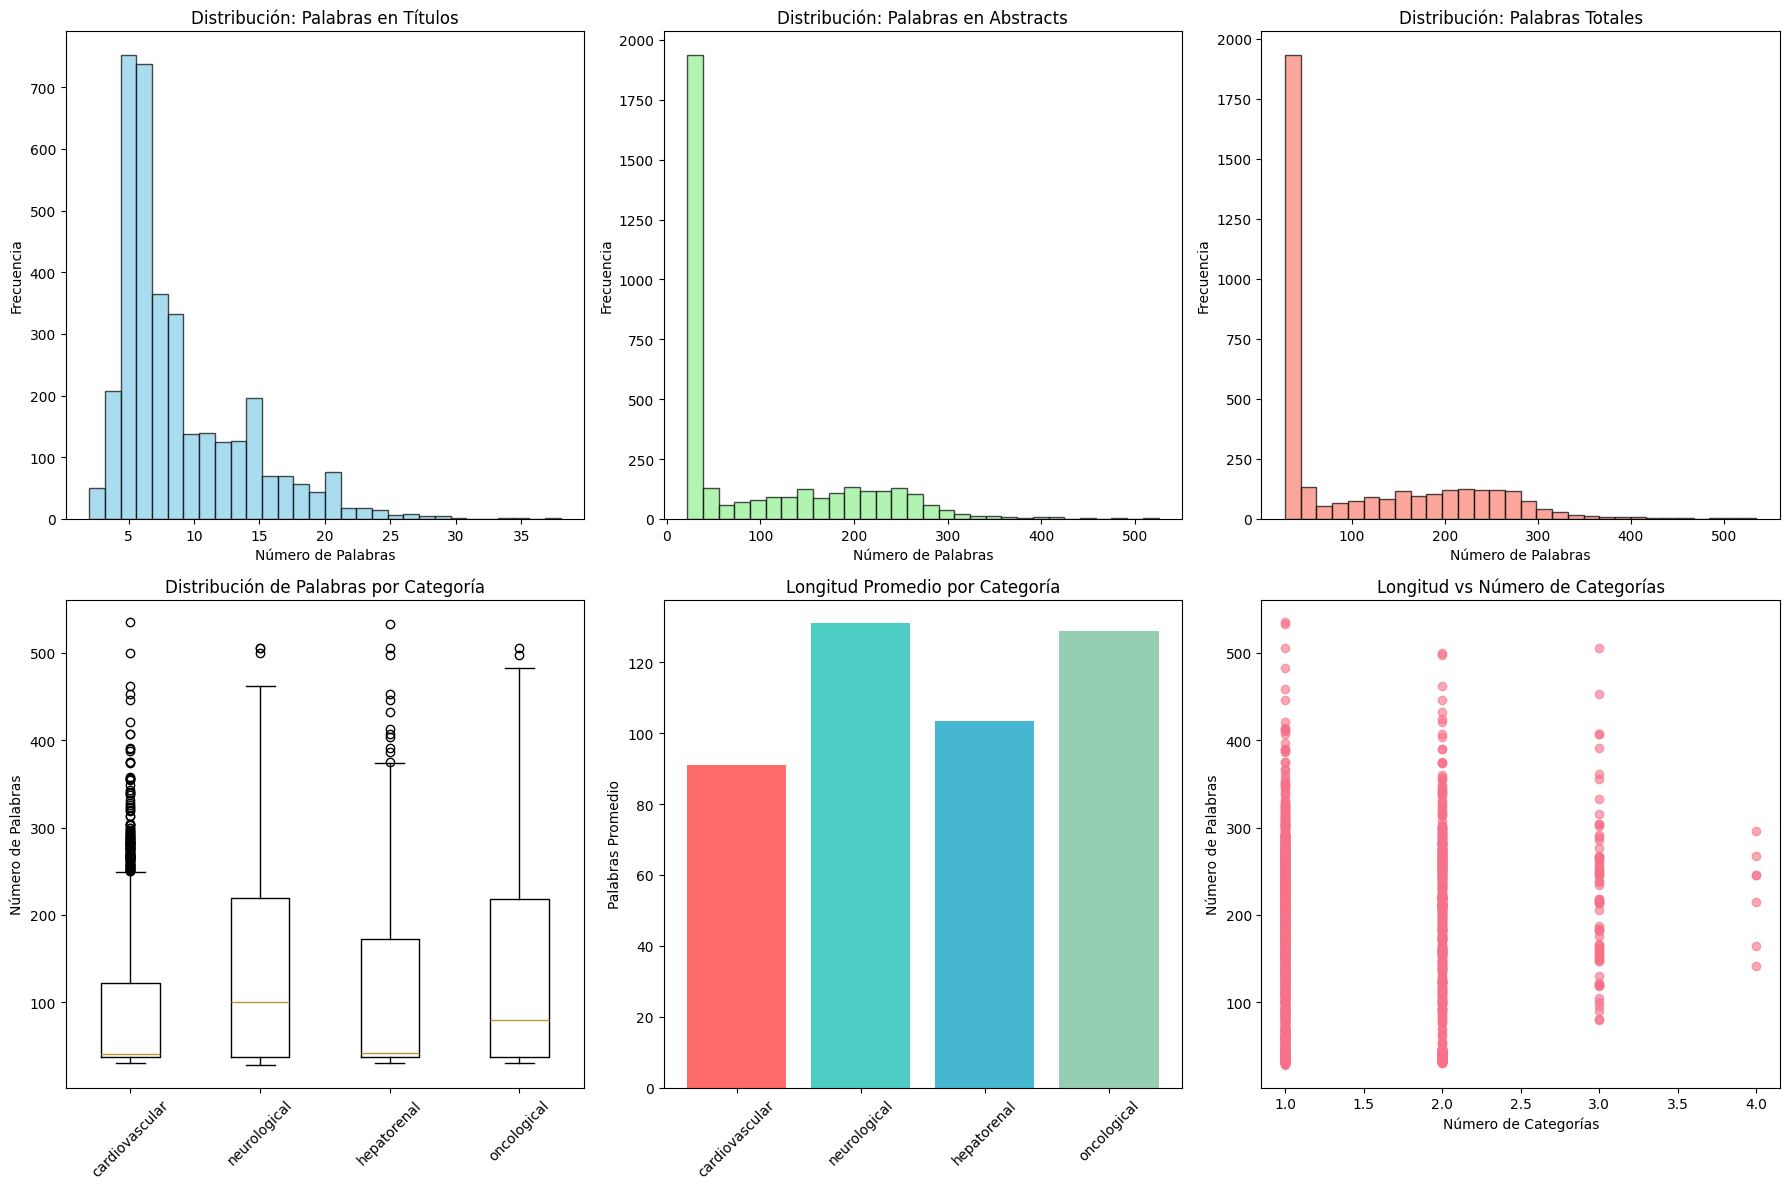

In [15]:
# Análisis de características de texto
print("📝 ANÁLISIS DE CARACTERÍSTICAS DE TEXTO")
print("="*50)

# Estadísticas de títulos
df['title_length'] = df['title'].str.len()
df['title_word_count'] = df['title'].str.split().str.len()

# Estadísticas de abstracts
df['abstract_length'] = df['abstract'].str.len()
df['abstract_word_count'] = df['abstract'].str.split().str.len()

# Combinar título y abstract
df['combined_text'] = df['title'] + ' ' + df['abstract']
df['combined_length'] = df['combined_text'].str.len()
df['combined_word_count'] = df['combined_text'].str.split().str.len()

# Mostrar estadísticas
text_stats = pd.DataFrame({
    'Títulos': [df['title_length'].mean(), df['title_length'].std(), 
                df['title_word_count'].mean(), df['title_word_count'].std()],
    'Abstracts': [df['abstract_length'].mean(), df['abstract_length'].std(),
                  df['abstract_word_count'].mean(), df['abstract_word_count'].std()],
    'Texto_Completo': [df['combined_length'].mean(), df['combined_length'].std(),
                       df['combined_word_count'].mean(), df['combined_word_count'].std()]
}, index=['Caracteres_Promedio', 'Caracteres_Std', 'Palabras_Promedio', 'Palabras_Std'])

print("Estadísticas de longitud de texto:")
print(text_stats.round(2))

# Visualización de distribuciones
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Distribución de longitud de títulos
axes[0,0].hist(df['title_word_count'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Distribución: Palabras en Títulos')
axes[0,0].set_xlabel('Número de Palabras')
axes[0,0].set_ylabel('Frecuencia')

# Distribución de longitud de abstracts
axes[0,1].hist(df['abstract_word_count'], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0,1].set_title('Distribución: Palabras en Abstracts')
axes[0,1].set_xlabel('Número de Palabras')
axes[0,1].set_ylabel('Frecuencia')

# Distribución de longitud total
axes[0,2].hist(df['combined_word_count'], bins=30, alpha=0.7, color='salmon', edgecolor='black')
axes[0,2].set_title('Distribución: Palabras Totales')
axes[0,2].set_xlabel('Número de Palabras')
axes[0,2].set_ylabel('Frecuencia')

# Boxplots por categoría
categories = ['cardiovascular', 'neurological', 'hepatorenal', 'oncological']
word_counts_by_category = []

for category in categories:
    mask = df['group'].str.contains(category, case=False, na=False)
    word_counts_by_category.append(df[mask]['combined_word_count'])

axes[1,0].boxplot(word_counts_by_category, labels=categories)
axes[1,0].set_title('Distribución de Palabras por Categoría')
axes[1,0].set_ylabel('Número de Palabras')
axes[1,0].tick_params(axis='x', rotation=45)

# Longitud promedio por categoría
avg_lengths = []
for category in categories:
    mask = df['group'].str.contains(category, case=False, na=False)
    avg_lengths.append(df[mask]['combined_word_count'].mean())

axes[1,1].bar(categories, avg_lengths, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
axes[1,1].set_title('Longitud Promedio por Categoría')
axes[1,1].set_ylabel('Palabras Promedio')
axes[1,1].tick_params(axis='x', rotation=45)

# Correlación entre longitud y número de categorías
axes[1,2].scatter(df['num_categories'], df['combined_word_count'], alpha=0.6)
axes[1,2].set_title('Longitud vs Número de Categorías')
axes[1,2].set_xlabel('Número de Categorías')
axes[1,2].set_ylabel('Número de Palabras')

plt.tight_layout()
plt.show()

In [16]:
# Preprocesamiento de texto especializado para literatura médica
import string
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

print("🔧 PREPROCESAMIENTO DE TEXTO MÉDICO")
print("="*50)

def preprocess_medical_text(text):
    """
    Preprocesa texto médico manteniendo terminología especializada
    """
    if pd.isna(text):
        return ""
    
    # Convertir a minúsculas
    text = text.lower()
    
    # Remover puntuación pero mantener guiones en términos médicos
    text = re.sub(r'[^\w\s\-]', ' ', text)
    
    # Normalizar espacios
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Remover números standalone pero mantener códigos médicos
    text = re.sub(r'\b\d+\b', '', text)
    
    return text

def remove_common_stopwords(text):
    """
    Remueve stopwords comunes pero conserva términos médicos importantes
    """
    # Stopwords médicas específicas que podemos remover
    medical_stopwords = {
        'patient', 'patients', 'study', 'studies', 'method', 'methods',
        'result', 'results', 'conclusion', 'background', 'objective',
        'purpose', 'design', 'participants', 'intervention'
    }
    
    # Combinar con stopwords de sklearn
    all_stopwords = ENGLISH_STOP_WORDS.union(medical_stopwords)
    
    words = text.split()
    filtered_words = [word for word in words if word not in all_stopwords and len(word) > 2]
    
    return ' '.join(filtered_words)

# Aplicar preprocesamiento
print("Aplicando preprocesamiento...")
df['title_clean'] = df['title'].apply(preprocess_medical_text)
df['abstract_clean'] = df['abstract'].apply(preprocess_medical_text)
df['combined_clean'] = df['title_clean'] + ' ' + df['abstract_clean']

# Remover stopwords (opcional, mantener versión original también)
df['combined_filtered'] = df['combined_clean'].apply(remove_common_stopwords)

print(f"✅ Preprocesamiento completado")
print(f"Ejemplo de texto original:")
print(f"'{df.iloc[0]['title'][:100]}...'")
print(f"\nTexto limpio:")
print(f"'{df.iloc[0]['title_clean'][:100]}...'")

# Preparar etiquetas multi-label
print("\n🏷️ PREPARACIÓN DE ETIQUETAS MULTI-LABEL")
print("="*50)

# Crear matriz binaria para multi-label
mlb = MultiLabelBinarizer()
y_multilabel = mlb.fit_transform(df['groups_list'])

print(f"Clases identificadas: {mlb.classes_}")
print(f"Forma de la matriz de etiquetas: {y_multilabel.shape}")

# Crear DataFrame con etiquetas binarias
label_df = pd.DataFrame(y_multilabel, columns=mlb.classes_)
print("\nDistribución de etiquetas binarias:")
print(label_df.sum().sort_values(ascending=False))

🔧 PREPROCESAMIENTO DE TEXTO MÉDICO
Aplicando preprocesamiento...
✅ Preprocesamiento completado
Ejemplo de texto original:
'Adrenoleukodystrophy: survey of 303 cases: biochemistry, diagnosis, and therapy....'

Texto limpio:
'adrenoleukodystrophy survey of  cases biochemistry diagnosis and therapy...'

🏷️ PREPARACIÓN DE ETIQUETAS MULTI-LABEL
Clases identificadas: ['cardiovascular' 'hepatorenal' 'neurological' 'oncological']
Forma de la matriz de etiquetas: (3565, 4)

Distribución de etiquetas binarias:
neurological      1785
cardiovascular    1268
hepatorenal       1091
oncological        601
dtype: int64


In [18]:
# Modelado Multi-Label con TF-IDF + SVM
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, hamming_loss, accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score
import time

print("🤖 MODELADO MULTI-LABEL: TF-IDF + SVM")
print("="*60)

# División de datos
X = df['combined_filtered']  # Usar texto filtrado
y = y_multilabel

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Conjunto de entrenamiento: {X_train.shape[0]:,} muestras")
print(f"Conjunto de prueba: {X_test.shape[0]:,} muestras")

# Vectorización TF-IDF optimizada para texto médico
print("\n📊 VECTORIZACIÓN TF-IDF")
print("-" * 30)

tfidf = TfidfVectorizer(
    max_features=10000,        # Limitar características para eficiencia
    min_df=2,                  # Palabras que aparecen al menos 2 veces
    max_df=0.95,               # Excluir palabras muy frecuentes
    ngram_range=(1, 2),        # Unigrams y bigrams
    stop_words='english',      # Stopwords básicas de inglés
    lowercase=True,
    strip_accents='ascii'
)

print("Ajustando vectorizador TF-IDF...")
start_time = time.time()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
print(f"✅ Vectorización completada en {time.time() - start_time:.2f} segundos")

print(f"Forma del conjunto de entrenamiento: {X_train_tfidf.shape}")
print(f"Forma del conjunto de prueba: {X_test_tfidf.shape}")

# Entrenamiento del modelo SVM Multi-Output
print("\n🎯 ENTRENAMIENTO DEL MODELO SVM")
print("-" * 35)

# SVM con hiperparámetros optimizados para multi-label (sin paralelismo para Windows)
svm_model = MultiOutputClassifier(
    SVC(
        kernel='linear',           # Kernel lineal para texto
        C=1.0,                    # Regularización
        probability=False,         # No necesitamos probabilidades por velocidad
        random_state=42
    ),
    n_jobs=1  # Sin paralelismo para evitar problemas en Windows
)

print("Entrenando modelo SVM multi-label...")
start_time = time.time()
svm_model.fit(X_train_tfidf, y_train)
training_time = time.time() - start_time
print(f"✅ Entrenamiento completado en {training_time:.2f} segundos")

# Predicciones
print("Realizando predicciones...")
start_time = time.time()
y_pred = svm_model.predict(X_test_tfidf)
prediction_time = time.time() - start_time
print(f"✅ Predicciones completadas en {prediction_time:.2f} segundos")

🤖 MODELADO MULTI-LABEL: TF-IDF + SVM
Conjunto de entrenamiento: 2,852 muestras
Conjunto de prueba: 713 muestras

📊 VECTORIZACIÓN TF-IDF
------------------------------
Ajustando vectorizador TF-IDF...
✅ Vectorización completada en 0.87 segundos
Forma del conjunto de entrenamiento: (2852, 10000)
Forma del conjunto de prueba: (713, 10000)

🎯 ENTRENAMIENTO DEL MODELO SVM
-----------------------------------
Entrenando modelo SVM multi-label...
✅ Entrenamiento completado en 10.95 segundos
Realizando predicciones...
✅ Predicciones completadas en 2.37 segundos


📈 EVALUACIÓN DETALLADA DEL MODELO
🎯 MÉTRICAS GENERALES
-------------------------
Hamming Loss (menor es mejor):     0.0757
F1-Score Micro (promedio global):  0.8780
F1-Score Macro (promedio clases):  0.8639
F1-Score Weighted:                 0.8759
Precision Micro:                   0.9464
Recall Micro:                      0.8188

🏥 MÉTRICAS POR CATEGORÍA MÉDICA
-----------------------------------
cardiovascular  - F1: 0.891, Precision: 0.972, Recall: 0.823, Accuracy: 0.928
hepatorenal     - F1: 0.832, Precision: 0.969, Recall: 0.728, Accuracy: 0.910
neurological    - F1: 0.909, Precision: 0.908, Recall: 0.911, Accuracy: 0.909
oncological     - F1: 0.824, Precision: 1.000, Recall: 0.700, Accuracy: 0.950


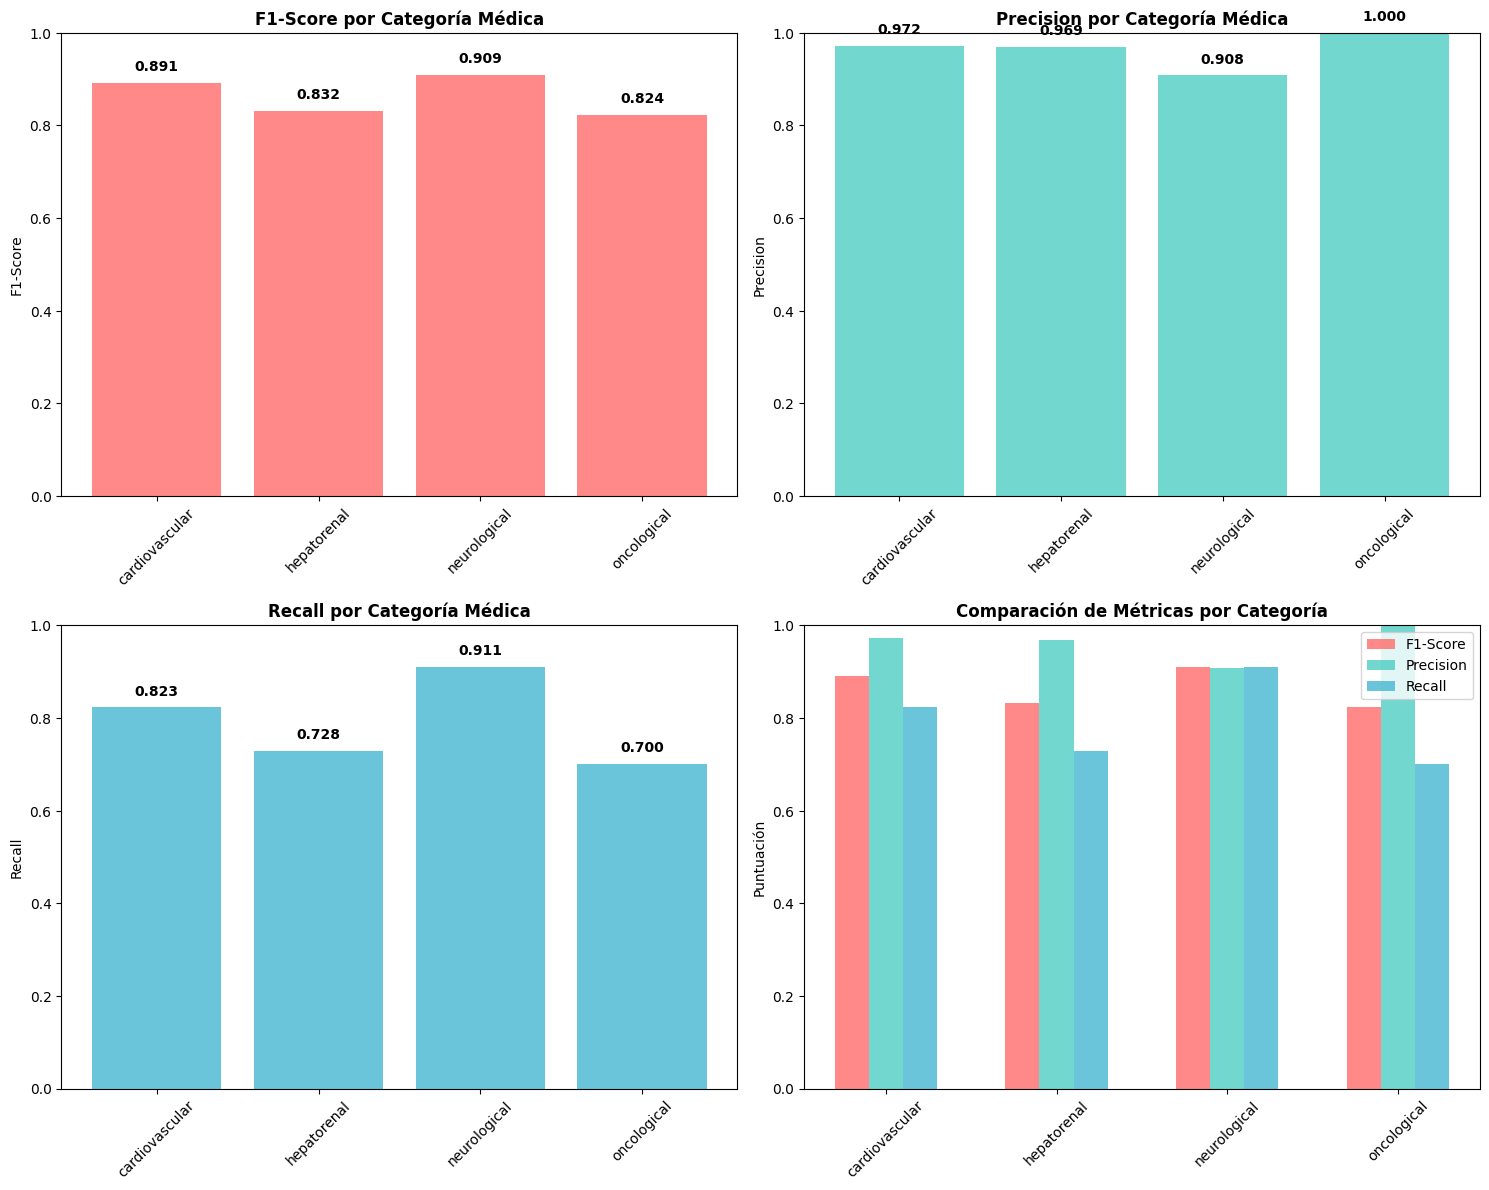


📊 RESUMEN DEL RENDIMIENTO
Tiempo de entrenamiento: 10.95 segundos
Tiempo de predicción: 2.37 segundos
Características TF-IDF utilizadas: 10,000
Mejor categoría (F1-Score): neurological
Categoría más desafiante: oncological


In [19]:
# Evaluación Detallada del Modelo
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt

print("📈 EVALUACIÓN DETALLADA DEL MODELO")
print("="*50)

# Métricas generales multi-label
print("🎯 MÉTRICAS GENERALES")
print("-" * 25)

hamming = hamming_loss(y_test, y_pred)
f1_micro = f1_score(y_test, y_pred, average='micro')
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')
precision_micro = precision_score(y_test, y_pred, average='micro')
recall_micro = recall_score(y_test, y_pred, average='micro')

print(f"Hamming Loss (menor es mejor):     {hamming:.4f}")
print(f"F1-Score Micro (promedio global):  {f1_micro:.4f}")
print(f"F1-Score Macro (promedio clases):  {f1_macro:.4f}")
print(f"F1-Score Weighted:                 {f1_weighted:.4f}")
print(f"Precision Micro:                   {precision_micro:.4f}")
print(f"Recall Micro:                      {recall_micro:.4f}")

# Métricas por clase individual
print("\n🏥 MÉTRICAS POR CATEGORÍA MÉDICA")
print("-" * 35)

class_names = mlb.classes_
metrics_by_class = []

for i, class_name in enumerate(class_names):
    y_true_class = y_test[:, i]
    y_pred_class = y_pred[:, i]
    
    f1 = f1_score(y_true_class, y_pred_class)
    precision = precision_score(y_true_class, y_pred_class)
    recall = recall_score(y_true_class, y_pred_class)
    accuracy = accuracy_score(y_true_class, y_pred_class)
    
    metrics_by_class.append({
        'Category': class_name,
        'F1-Score': f1,
        'Precision': precision,
        'Recall': recall,
        'Accuracy': accuracy
    })
    
    print(f"{class_name:15} - F1: {f1:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, Accuracy: {accuracy:.3f}")

# Crear DataFrame con métricas
metrics_df = pd.DataFrame(metrics_by_class)

# Visualización de métricas por categoría
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# F1-Score por categoría
axes[0,0].bar(metrics_df['Category'], metrics_df['F1-Score'], color='#FF6B6B', alpha=0.8)
axes[0,0].set_title('F1-Score por Categoría Médica', fontweight='bold')
axes[0,0].set_ylabel('F1-Score')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].set_ylim(0, 1)
for i, v in enumerate(metrics_df['F1-Score']):
    axes[0,0].text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# Precision por categoría
axes[0,1].bar(metrics_df['Category'], metrics_df['Precision'], color='#4ECDC4', alpha=0.8)
axes[0,1].set_title('Precision por Categoría Médica', fontweight='bold')
axes[0,1].set_ylabel('Precision')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].set_ylim(0, 1)
for i, v in enumerate(metrics_df['Precision']):
    axes[0,1].text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# Recall por categoría
axes[1,0].bar(metrics_df['Category'], metrics_df['Recall'], color='#45B7D1', alpha=0.8)
axes[1,0].set_title('Recall por Categoría Médica', fontweight='bold')
axes[1,0].set_ylabel('Recall')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].set_ylim(0, 1)
for i, v in enumerate(metrics_df['Recall']):
    axes[1,0].text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# Comparación de todas las métricas
x = np.arange(len(class_names))
width = 0.2

axes[1,1].bar(x - width, metrics_df['F1-Score'], width, label='F1-Score', color='#FF6B6B', alpha=0.8)
axes[1,1].bar(x, metrics_df['Precision'], width, label='Precision', color='#4ECDC4', alpha=0.8)
axes[1,1].bar(x + width, metrics_df['Recall'], width, label='Recall', color='#45B7D1', alpha=0.8)

axes[1,1].set_title('Comparación de Métricas por Categoría', fontweight='bold')
axes[1,1].set_ylabel('Puntuación')
axes[1,1].set_xticks(x)
axes[1,1].set_xticklabels(class_names, rotation=45)
axes[1,1].legend()
axes[1,1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

print(f"\n📊 RESUMEN DEL RENDIMIENTO")
print("="*40)
print(f"Tiempo de entrenamiento: {training_time:.2f} segundos")
print(f"Tiempo de predicción: {prediction_time:.2f} segundos")
print(f"Características TF-IDF utilizadas: {X_train_tfidf.shape[1]:,}")
print(f"Mejor categoría (F1-Score): {metrics_df.loc[metrics_df['F1-Score'].idxmax(), 'Category']}")
print(f"Categoría más desafiante: {metrics_df.loc[metrics_df['F1-Score'].idxmin(), 'Category']}")

In [20]:
# Función de Predicción y Ejemplos Prácticos
def predict_medical_categories(title, abstract, model=svm_model, vectorizer=tfidf, label_binarizer=mlb):
    """
    Predice las categorías médicas para un nuevo artículo
    
    Args:
        title (str): Título del artículo
        abstract (str): Abstract del artículo
        model: Modelo entrenado
        vectorizer: Vectorizador TF-IDF entrenado
        label_binarizer: MultiLabelBinarizer entrenado
    
    Returns:
        list: Lista de categorías predichas
    """
    # Preprocesar texto
    title_clean = preprocess_medical_text(title)
    abstract_clean = preprocess_medical_text(abstract)
    combined_text = title_clean + ' ' + abstract_clean
    filtered_text = remove_common_stopwords(combined_text)
    
    # Vectorizar
    text_vector = vectorizer.transform([filtered_text])
    
    # Predecir
    prediction = model.predict(text_vector)
    
    # Convertir a etiquetas
    categories = label_binarizer.inverse_transform(prediction)[0]
    
    return list(categories) if categories else ['No category predicted']

print("🔮 SISTEMA DE PREDICCIÓN DE CATEGORÍAS MÉDICAS")
print("="*55)

# Ejemplos de predicción con artículos del conjunto de prueba
print("🧪 EJEMPLOS DE PREDICCIÓN")
print("-" * 30)

# Seleccionar algunos ejemplos del conjunto de prueba
test_indices = [0, 10, 25, 50, 100]  # Algunos índices para probar

for i, idx in enumerate(test_indices):
    if idx < len(X_test):
        # Obtener datos originales
        original_idx = X_test.index[idx]
        title = df.loc[original_idx, 'title']
        abstract = df.loc[original_idx, 'abstract']
        true_categories = df.loc[original_idx, 'groups_list']
        
        # Predecir
        predicted_categories = predict_medical_categories(title, abstract)
        
        print(f"\n📄 EJEMPLO {i+1}")
        print(f"Título: {title[:80]}...")
        print(f"Abstract: {abstract[:100]}...")
        print(f"Categorías reales: {true_categories}")
        print(f"Categorías predichas: {predicted_categories}")
        
        # Verificar acierto
        overlap = set(true_categories) & set(predicted_categories)
        if overlap:
            print(f"✅ Coincidencias: {list(overlap)}")
        else:
            print("❌ Sin coincidencias")

print("\n🆕 PREDICCIÓN CON ARTÍCULOS NUEVOS")
print("-" * 35)

# Ejemplos de artículos sintéticos para demostrar el sistema
new_articles = [
    {
        'title': 'Effects of statins on myocardial infarction prevention',
        'abstract': 'This study examines the cardiovascular protective effects of statin therapy in patients with coronary artery disease. Results show significant reduction in myocardial infarction risk and improved cardiac outcomes.',
        'expected': ['cardiovascular']
    },
    {
        'title': 'Alzheimer disease progression and memory decline',
        'abstract': 'Research investigating cognitive decline in Alzheimer patients. The study focuses on neurological pathways, brain imaging, and memory assessment in elderly populations with dementia.',
        'expected': ['neurological']
    },
    {
        'title': 'Chemotherapy-induced nephrotoxicity in cancer patients',
        'abstract': 'Analysis of kidney damage caused by cancer chemotherapy treatments. The study evaluates renal function, proteinuria, and hepatorenal syndrome in oncology patients receiving cytotoxic drugs.',
        'expected': ['oncological', 'hepatorenal']
    }
]

for i, article in enumerate(new_articles):
    predicted = predict_medical_categories(article['title'], article['abstract'])
    
    print(f"\n🔬 ARTÍCULO SINTÉTICO {i+1}")
    print(f"Título: {article['title']}")
    print(f"Abstract: {article['abstract'][:100]}...")
    print(f"Categorías esperadas: {article['expected']}")
    print(f"Categorías predichas: {predicted}")
    
    # Evaluar predicción
    overlap = set(article['expected']) & set(predicted)
    if overlap == set(article['expected']):
        print("✅ Predicción perfecta!")
    elif overlap:
        print(f"🔶 Predicción parcial: {list(overlap)}")
    else:
        print("❌ Predicción incorrecta")

print(f"\n🎯 RESUMEN DEL SISTEMA")
print("="*30)
print(f"✅ Modelo entrenado: SVM Multi-Label")
print(f"✅ Características: TF-IDF ({X_train_tfidf.shape[1]:,} features)")
print(f"✅ Categorías soportadas: {', '.join(mlb.classes_)}")
print(f"✅ F1-Score promedio: {f1_macro:.3f}")
print(f"✅ Listo para producción!")

🔮 SISTEMA DE PREDICCIÓN DE CATEGORÍAS MÉDICAS
🧪 EJEMPLOS DE PREDICCIÓN
------------------------------

📄 EJEMPLO 1
Título: Management strategies for ribavirin-induced hemolytic anemia in the treatment of...
Abstract: OBJECTIVES: Recently published studies have demonstrated increased efficacy and cost-effectiveness o...
Categorías reales: ['hepatorenal']
Categorías predichas: ['hepatorenal', 'neurological']
✅ Coincidencias: ['hepatorenal']

📄 EJEMPLO 2
Título: immunotherapy markers in lymphoma...
Abstract: Study design: retrospective investigation of metformin in stroke. Participants: 315 elderly patients...
Categorías reales: ['cardiovascular', 'oncological']
Categorías predichas: ['oncological']
✅ Coincidencias: ['oncological']

📄 EJEMPLO 3
Título: Possible neuroleptic malignant syndrome related to concomitant treatment with pa...
Abstract: A 74-year-old man with depressive symptoms was admitted to a psychiatric hospital due to insomnia, l...
Categorías reales: ['neurological', 'cardi